# Affinity fitness landscape inference

Model writeup: https://www.overleaf.com/read/nbqgsvvstjfp

## Numerical solver

Our data includes the relaxation phase, so we solve numerically without a traveling-wave anstatz.

In [1]:
import diffrax as dx
import jax
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from jax.config import config
config.update("jax_enable_x64", True)

import jaxopt

Phenotype discretization

In [2]:
n = 2001
x = np.linspace(-10, 10, n)
assert x[n // 2] == 0

Right-hand side function for ODE system

In [3]:
# @jax.jit
# def f(x, α, β, γ, ν):
#     return α / ((1 + jnp.exp(-β * (x - γ))) ** (1 / ν))

@jax.jit
def f(x, α, β, γ):
    return - α * (jax.nn.softplus(-γ * (x - β)) - jax.nn.softplus(β * γ)) / γ
    # jax.nn.relu(-(x - γ))

f_prime = jax.jit(jax.grad(f, argnums=0))

@jax.jit
def term(t, p, args):
    x, α, β, γ, μ, Q = args
    x_mean = x @ p
    return f_prime(x_mean, α, β, γ) * (x - x_mean) * p + μ * p @ Q


Define parameters

In [4]:
α = 0.1
β = 0.5
γ = 10.0
μ = 0.5

Plot affinity-fitness response function

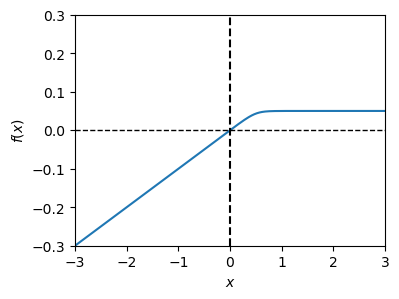

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x, f(x, α, β, γ))
ax.axhline(0, color="k", ls="--", lw=1)
ax.axvline(0, color="k", ls="--")
ax.set_xlim(-3, 3)
ax.set_ylim(-3 * α, 3 * α)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
plt.show()


We fix a mutation kernel that resembles the distribution of affinity effects in the DMS data.

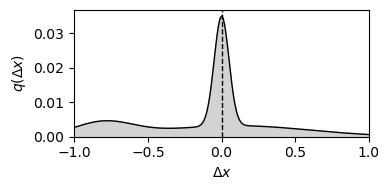

In [6]:
Q = jnp.zeros((n, n))
q = np.zeros(n)
q_means = [0, 0.1, -0.8]
q_stds = [0.05, 0.5, 0.2]
q_weights = [2.0, 2.0, 1.0]
# q_means = [-0.01]
# q_stds = [0.05]
# q_weights = [1.0]
for q_weight, q_mean, q_std in zip(q_weights, q_means, q_stds):
    Q += q_weight * jax.scipy.stats.norm.pdf(x[None, :], x[:, None] + q_mean, q_std)
    q += q_weight * jax.scipy.stats.norm.pdf(x, q_mean, q_std)
Q /= Q.sum(1, keepdims=True)
Q = Q.at[jnp.diag_indices(len(Q))].set(-Q.sum(1) + jnp.diag(Q))
q /= q.sum()
assert np.allclose(Q.sum(1), 0)
assert np.allclose(q.sum(), 1)

plt.figure(figsize=(4, 2))
plt.fill_between(x, q, color='lightgrey')
plt.plot(x, q, lw=1, color='k')
plt.axvline(0, color='k', ls='--', lw=1)
plt.xlim(-1, 1)
plt.ylim(0, None)
plt.xlabel("$\Delta x$")
plt.ylabel("$q(\Delta x)$")
plt.tight_layout()
plt.show()

Initial condition $\mathbf{p}(0) = \mathbf{e}_i$, where $x_i = 0$.

In [7]:
p0 = jnp.zeros(n)
p0 = p0.at[n // 2].set(1.0)

Solve

In [8]:
t = np.linspace(0, 20, 81)
m = len(t)

ode_term = dx.ODETerm(term)
rtol = 1e-10
atol = 1e-10
max_steps = 10000
dt0 = (t.max() - t.min()) / 100
solver = dx.Tsit5()
stepsize_controller = dx.PIDController(rtol=rtol, atol=atol)

@jax.jit
def p_solve(x, t, α, β, γ, μ, Q):
    sol = dx.diffeqsolve(ode_term, solver, args=(x, α, β, γ, μ, Q),
                         t0=0, t1=t[-1], dt0=dt0,
                         y0=p0,
                         saveat=dx.SaveAt(ts=t),
                         stepsize_controller=stepsize_controller,
                         max_steps=max_steps,
                         )
    return sol.ys.T

p = p_solve(x, t, α, β, γ, μ, Q)
p.shape

(2001, 81)

Plot limit parameters

In [9]:
p_max = 0.02
x_min = -3
x_max = 3

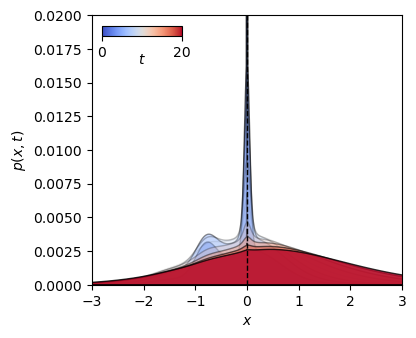

In [10]:
fig, ax = plt.subplots(figsize=(4, 3.5))
plt.axvline(0, color='k', ls='--', lw=1)
colors = plt.cm.coolwarm(t / t[-1])
for j in range(0, len(t), 10):
    ax.fill_between(x, p[:, j],
             edgecolor="k",
             facecolor=colors[j],
             alpha=float(0.8 * (0.1 + 0.9 * 2 * abs(t[j] / t[-1] - 1 / 2))),
             )
plt.xlim(x_min, x_max)
plt.ylim(0, p_max)
plt.xlabel('$x$')
plt.ylabel('$p(x,t)$')
cbar = plt.colorbar(
             mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=t[-1]),
                                   cmap="coolwarm"),
             orientation='horizontal',
             cax=fig.add_axes([.15, 0.82, 0.2, 0.03]),
)
cbar.set_label(label='$t$', size=10, labelpad=-5)
plt.show()

Quartiles of the affinity distribution over time

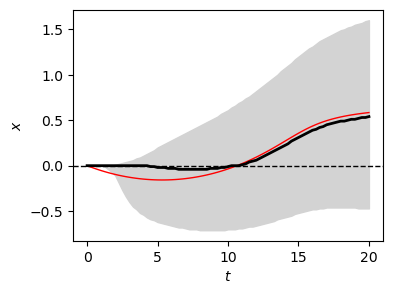

In [11]:
# find the indices of the quartiles
q1 = np.array([x[np.cumsum(p[:, j], axis=0).searchsorted(0.25, side="right")] for j in range(len(t))])
q2 = np.array([x[np.cumsum(p[:, j], axis=0).searchsorted(0.50, side="right")] for j in range(len(t))])
q3 = np.array([x[np.cumsum(p[:, j], axis=0).searchsorted(0.75, side="right")] for j in range(len(t))])

fig, ax = plt.subplots(figsize=(4, 3))
plt.axhline(0, color="k", ls="--", lw=1)
ax.fill_between(t, q1, q3, color="lightgrey")
ax.plot(t, x @ p, "r-", lw=1)
# ax.plot(t, q1, "k--", lw=1)
# ax.plot(t, q3, "k--", lw=1)
ax.plot(t, q2, "k", lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")
# ax.set_ylim(x_moment_min, x_moment_max)
plt.show()

In [12]:
assert np.allclose(p.sum(0), 1), p.sum(0)

Animation

In [13]:
fps = 24

fig, ax = plt.subplots(#2, 1,
                       #sharex=False, sharey=False,
                       figsize=(6, 4),
                    #    height_ratios=(2, 1),
                       )

def init():
    # ax[0].set_xlabel(r"x")
    ax.set_xlabel(r"$\Delta$ affinity")
    # ax[0].set_ylabel(r"$p(x, t)$")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(α * x_min, α * x_max)
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.plot(x, f(x, α, β, γ), "k", lw=1)

    # ax[1].set_xlim(0, t[-1])
    # ax[1].set_xlabel(r"$t$")
    # # ax[1].set_ylabel(r"$x$")
    # ax[1].set_ylabel(r"$\Delta$ affinity")
    # ax[1].set_ylim(x_moment_min, x_moment_max)

    fig.tight_layout()

def update(frame):
    # ax[0].clear()
    # remove the previous frame
    for c in ax.collections:
        c.remove()
    ax.fill_between(x, α * x_max * p[:, frame] / p_max,
                       color="lightgrey",
                       facecolor=colors[frame],
                       lw=1,
                       edgecolor="k",
                       animated=True)
    ax.set_title(rf"$t = {t[frame]:.1f}$")

    # # ax[1].clear()  
    # ax[1].plot(t[:(frame + 1)], x_mean[:(frame + 1)], "C0", label=r"mean" if frame == 0 else None, animated=True)
    # ax[1].plot(t[:(frame + 1)], x_std[:(frame + 1)], "C1", label=r"std" if frame == 0 else None, animated=True)
    # ax[1].legend(loc="upper left")

ani = animation.FuncAnimation(fig, update, init_func=init, frames=len(t), interval=1000/fps)

# save
ani.save("output/affinity-fitness-response/affinity-fitness-response.gif", fps=fps, dpi=200)

html_video = HTML(ani.to_jshtml())
plt.close()
html_video

MovieWriter ffmpeg unavailable; using Pillow instead.
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_86639/1797583137.py:24: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


## Sampling

In [14]:
sampling_times = np.array([5, 8, 11, 14, 17, 20], dtype=np.float64)
sample_sizes = np.array([100, 1000, 1000, 1000, 1000, 1000])
n_samples = len(sampling_times)

In [15]:
p_samples = p_solve(x, sampling_times, α, β, γ, μ, Q)

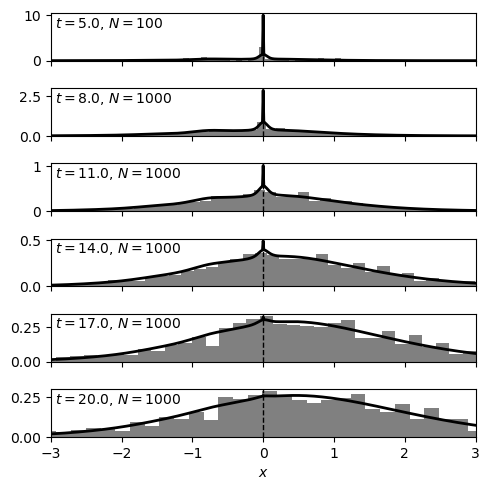

In [16]:
key = jax.random.PRNGKey(0)

fig, axes = plt.subplots(n_samples, 1, figsize=(5, 5), sharex=True)

samples = []
for sampling_time, sample_size, p_sample, ax in zip(sampling_times, sample_sizes, p_samples.T, axes):
    samples.append([])
    for sample_idx in jax.random.choice(key, n, shape=(sample_size,), p=p_sample):
        samples[-1].append(sample_idx)
    samples[-1] = np.array(samples[-1])
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.hist(x[samples[-1]], bins=50, density=True, color='grey')
    ax.plot(x, p_sample / (x[1] - x[0]), lw=2, color='k')
    ax.annotate(rf"$t={sampling_time}$, $N={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
plt.tight_layout()
plt.show()

## Maximum likelihood estimation

In [17]:
affinity_bin_counts = np.zeros((n, n_samples))
for i, sample in enumerate(samples):
    for j in samples[i]:
        k = np.searchsorted(x, x[j])
        affinity_bin_counts[k, i] += 1

assert all(affinity_bin_counts.sum(0) == sample_sizes)

affinity_bin_counts.shape

(2001, 6)

In [18]:
@eqx.filter_jit
def neg_log_likelihood(params, Q, affinity_bin_counts, sampling_times):
    α, β, γ, μ = jnp.exp(params)
    return -(affinity_bin_counts * jnp.log(p_solve(x, sampling_times, α, β, γ, μ, Q))).sum()

@eqx.filter_jit
@eqx.filter_value_and_grad
def neg_log_likelihood_value_and_grad(params, Q, affinity_bin_counts, sampling_times):
    return neg_log_likelihood(params, Q, affinity_bin_counts, sampling_times)

To maximize the likelihood, we use the accelerated gradient descent with adaptive line search, backpropagating through the PDE solver.

In [19]:
params_true = jnp.log(jnp.array([α, β, γ, μ]))
params_true

Array([-2.30258509, -0.69314718,  2.30258509, -0.69314718], dtype=float64)

In [20]:
params0 = jnp.log(jnp.array([0.2, 0.75, 10., 0.5]))

opt = jaxopt.GradientDescent(
                    neg_log_likelihood_value_and_grad,
                    value_and_grad=True,
                    jit=False,
                    implicit_diff=False,
                    verbose=True,
                    maxiter=100, tol=1e-2,
                    stepsize=1e-4,
                    acceleration=False,
                    )

params, state = opt.run(params0, Q, affinity_bin_counts, sampling_times)

error: 1026.422755005976
error: 898.29873439621
error: 777.1780640370005
error: 661.0893813646074
error: 563.0828612759526
error: 485.34543420612175
error: 422.88810916097657
error: 370.6049991912891
error: 325.1022461001976
error: 284.5744343842371
error: 248.25490056232962
error: 215.85804764655896
error: 187.20331208249362
error: 162.0585759018662
error: 140.12368770177753
error: 121.06386166158065
error: 104.54368611759932
error: 90.24825228261227
error: 77.8923930556861
error: 67.22298939965863
error: 58.01769289427651
error: 50.0823321398736
error: 43.247806602208165
error: 37.36717270728806
error: 32.31288863397922
error: 27.974377737051302
error: 24.255859254102063
error: 21.07442512466928
error: 18.35833148200122
error: 16.045475377361125
error: 14.082031762926198
error: 12.421232312391755
error: 11.022275858086969
error: 9.84937008829905
error: 8.870913489108336
error: 8.058831673390095
error: 7.388078813340209
error: 6.836300715551003
error: 6.383634322463258
error: 6.012597

In [21]:
jnp.exp(params), jnp.exp(params0), jnp.exp(params_true)

(Array([0.1022293 , 0.5320492 , 9.98882038, 0.49414354], dtype=float64),
 Array([ 0.2 ,  0.75, 10.  ,  0.5 ], dtype=float64),
 Array([ 0.1,  0.5, 10. ,  0.5], dtype=float64))

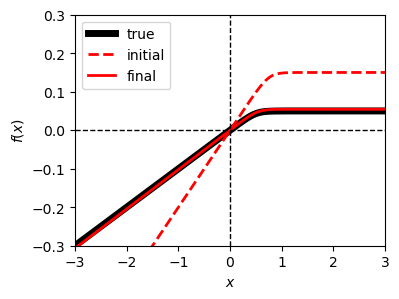

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x, f(x, *jnp.exp(params_true[:-1])), "k", lw=5, label="true")
ax.plot(x, f(x, *jnp.exp(params0[:-1])), "r--", lw=2, label="initial")
ax.plot(x, f(x, *jnp.exp(params[:-1])), "r", lw=2, label="final")
ax.axhline(0, color="k", ls="--", lw=1)
ax.axvline(0, color="k", ls="--", lw=1)
ax.set_xlim(x_min, x_max)
ax.set_ylim(x_min * α, x_max * α)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
ax.legend()
plt.show()

Plot likelihood surface

In [23]:
neg_log_likelihood_vmap = jax.jit(jax.vmap(neg_log_likelihood, in_axes=(0, None, None, None)))
# trigger jit
neg_log_likelihood_vmap(jnp.array([params, params0]), Q, affinity_bin_counts, sampling_times)

αs = np.linspace(0.05, 0.3, 50)
βs = np.linspace(0.0, 1.0, 51)

log_likelihood_surface = -neg_log_likelihood_vmap(jnp.log(jnp.array([[α_, β_, γ, μ]
                                                                   for α_ in αs for β_ in βs])
                                                          ),
                                                  Q, affinity_bin_counts, sampling_times
                                                  ).reshape(len(αs), len(βs))

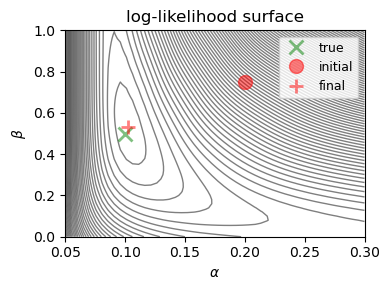

In [24]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.contour(αs, βs,
           log_likelihood_surface.T,
           100,
           colors="k",
           linestyles="solid",
           linewidths=1, alpha=0.5,
           )
ax.plot(jnp.exp(params_true[0]), jnp.exp(params_true[1]), "gx", alpha=0.5, ms=10, mew=2, label="true")
ax.plot(jnp.exp(params0[0]), jnp.exp(params0[1]), "ro", alpha=0.5, ms=10, label="initial")
ax.plot(jnp.exp(params[0]), jnp.exp(params[1]), "r+", alpha=0.5, ms=10, mew=2, label="final")
ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")
ax.set_title(r"log-likelihood surface")
plt.tight_layout()
plt.show()

Assess reconstruction accuracy

In [25]:
p_samples_inferred = p_solve(x, sampling_times, *jnp.exp(params), Q)

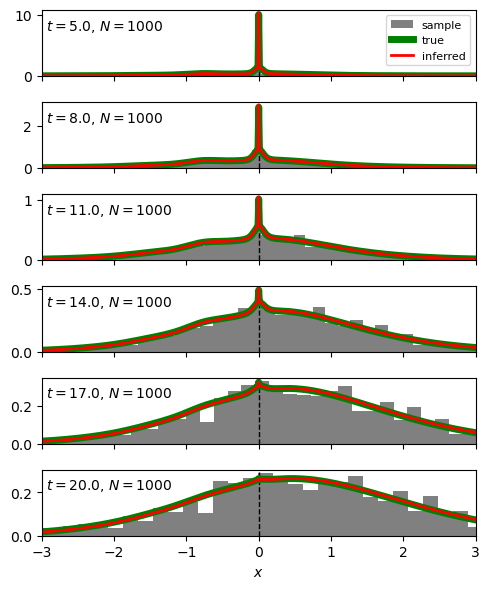

In [26]:
fig, axes = plt.subplots(n_samples, 1, figsize=(5, 6), sharex=True)
for sampling_time, sample, p_sample, p_sample_inferred, ax in zip(sampling_times, samples, p_samples.T, p_samples_inferred.T, axes):
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.hist(x[sample], bins=50, density=True, color='grey',
            label="sample" if sampling_time == sampling_times[0] else None)
    ax.plot(x, p_sample / (x[1] - x[0]), lw=5, color='green',
            label="true" if sampling_time == sampling_times[0] else None)
    ax.plot(x, p_sample_inferred / (x[1] - x[0]), lw=2, color='r', alpha=1,
    label="inferred" if sampling_time == sampling_times[0] else None)
    ax.annotate(rf"$t={sampling_time}$, $N={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
axes[0].legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

## Real data

In [94]:
import pandas as pd

df = pd.read_csv("output/10x/data.csv")[["time (days)", "mouse", "delta_bind_CGG"]].dropna()
df["time (days)"] = df["time (days)"].astype(np.float64)
df.rename(columns={"time (days)": "t", "delta_bind_CGG": "x"}, inplace=True)
df

,t,mouse,x
0,14.0,D14M1,0.85701
2,8.0,D8M1,0.00000
3,8.0,D8M4,0.00000
4,11.0,D11M1,0.85566
5,11.0,D11M1,0.00000
...,...,...,...
7293,17.0,D17M3,1.37620
7294,14.0,D14M3,0.22140
7295,11.0,D11M3,0.82072
7296,17.0,D17M4,2.11127


In [95]:
# Filter extreme values
df = df.loc[(df.x < 3) & (df.x > -2)]

In [96]:
sampling_times = []
samples = []
sample_sizes = []

for t, group in df.groupby("t").x:
    sampling_times.append(t)
    samples.append(group.values)
    sample_sizes.append(len(group))

sampling_times = np.array(sampling_times)
sample_sizes = np.array(sample_sizes)

n_samples = len(sampling_times)

affinity_bin_counts = np.zeros((n, n_samples))
for i, sample in enumerate(samples):
    for xx in sample:
        k = np.searchsorted(x, xx)
        affinity_bin_counts[k, i] += 1

assert all(affinity_bin_counts.sum(0) == sample_sizes)

affinity_bin_counts.shape

(2001, 6)

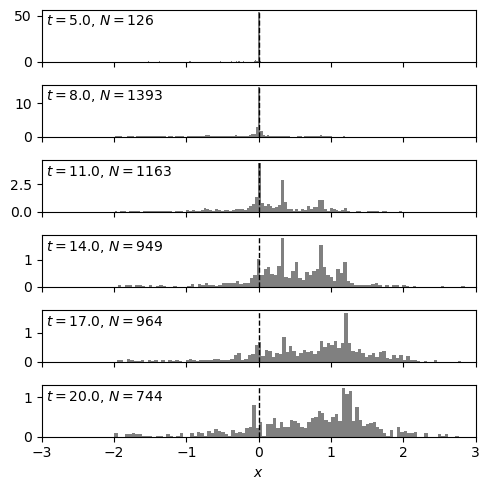

In [97]:
key = jax.random.PRNGKey(0)

fig, axes = plt.subplots(n_samples, 1, figsize=(5, 5), sharex=True)

for sample, sampling_time, sample_size, ax in zip(samples, sampling_times, sample_sizes, axes):
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.hist(sample, bins=100, density=True, color='grey')
    ax.annotate(rf"$t={sampling_time}$, $N={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
plt.tight_layout()
plt.show()

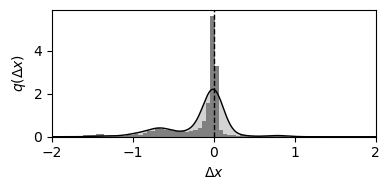

In [171]:
df_mut = pd.read_csv("output/mutations/data.csv")[["mutation rate", "delta_bind_CGG"]].dropna()

# clip
clipped_idxs = df_mut.query("delta_bind_CGG > -1.5 & delta_bind_CGG < 1.5").index

kde = scipy.stats.gaussian_kde(df_mut.loc[clipped_idxs, "delta_bind_CGG"], weights=df_mut.loc[clipped_idxs, "mutation rate"])

q = kde.pdf(x)

plt.figure(figsize=(4, 2))
plt.fill_between(x, q, color='lightgrey')
plt.plot(x, q, lw=1, color='k')
plt.hist(df_mut.delta_bind_CGG.values, bins=100, density=True, color='grey')
plt.axvline(0, color='k', ls='--', lw=1)
plt.xlim(-2, 2)
plt.ylim(0, None)
plt.xlabel("$\Delta x$")
plt.ylabel("$q(\Delta x)$")
plt.tight_layout()
plt.show()

q /= q.sum()
assert np.allclose(q.sum(), 1)
# assert np.allclose(np.trapz(q, x), 1)

In [172]:
Q = kde.pdf((x[None, :] - x[:, None]).flatten()).reshape(n, n)
Q[jnp.diag_indices(n)] = 0
Q /= Q.sum(1, keepdims=True)
Q[jnp.diag_indices(n)] = -Q.sum(1)

assert np.allclose(Q.sum(1), 0)
assert np.allclose(np.diag(Q), -1)

In [173]:
# params0 = jnp.log(jnp.array([0.2, 0.75, 0.4, 10.0]))
params0 = params_true

opt = jaxopt.GradientDescent(
                    neg_log_likelihood_value_and_grad,
                    value_and_grad=True,
                    jit=False,
                    implicit_diff=False,
                    verbose=True,
                    maxiter=20, tol=1e-2,
                    stepsize=1e-4,
                    acceleration=True,
                    )

# params = params0
params, state = opt.run(params, Q, affinity_bin_counts, sampling_times)

error: 1027.7924935204733
error: 409.7721635716719
error: 334.6552094173434
error: 287.18651698727706
error: 225.18604482247954
error: 158.7068648845203
error: 97.40221697555052
error: 47.45741292047586
error: 13.138677956809085
error: 14.408578077908485
error: 23.723427269456558
error: 25.0995944072169
error: 21.45095989730864
error: 16.263436252805885
error: 12.75796045683425
error: 12.411602683266333
error: 13.612916117410606
error: 14.629678346784607
error: 15.102815980312988


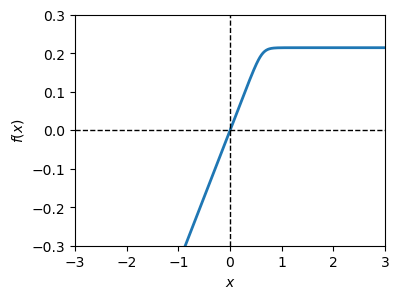

In [174]:
fig, ax = plt.subplots(figsize=(4, 3))
# ax.plot(x, f(x, *jnp.exp(params0[:-1])), "r--", lw=2, label="initial")
ax.plot(x, f(x, *jnp.exp(params)[:-1]), lw=2)
ax.axhline(0, color="k", ls="--", lw=1)
ax.axvline(0, color="k", ls="--", lw=1)
ax.set_xlim(x_min, x_max)
ax.set_ylim(x_min * α, x_max * α)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
plt.show()

In [175]:
p_samples_inferred = p_solve(x, sampling_times, *jnp.exp(params), Q)

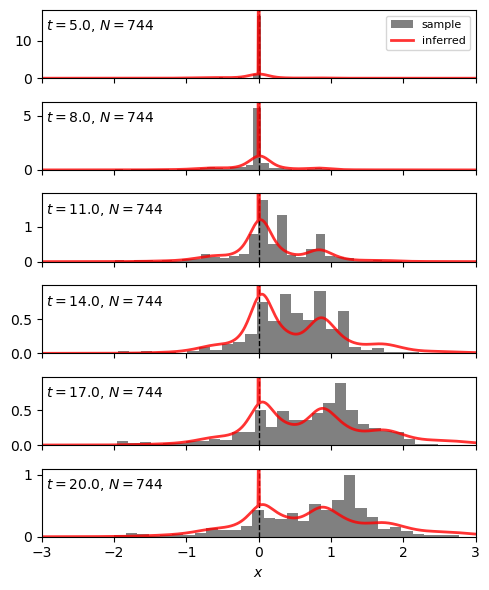

In [176]:
fig, axes = plt.subplots(n_samples, 1, figsize=(5, 6), sharex=True, sharey=False)
for sampling_time, sample, p_sample_inferred, ax in zip(sampling_times, samples, p_samples_inferred.T, axes):
    ax.axvline(0, color='k', ls='--', lw=1)
    cts, _, _ = ax.hist(sample, bins=30, density=True, color='grey',
            label="sample" if sampling_time == sampling_times[0] else None)
    ax.plot(x, p_sample_inferred / (x[1] - x[0]), lw=2, color='r', alpha=0.8,
            label="inferred" if sampling_time == sampling_times[0] else None)
    ax.annotate(rf"$t={sampling_time}$, $N={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
    ax.set_ylim(0, 1.1 * cts.max())
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
axes[0].legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()